# Определение перспективного тарифа для телеком компании

В нашем распоряжении данные компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

# Задача

Необходимо сделать анализ тарифов на выборке пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

***Тариф «Смарт»***

    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:

    минута разговора: 3 рубля
    сообщение: 3 рубля
    1 Гб интернет-трафика: 200 рублей
    
***Тариф «Ультра»***

    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:

    минута разговора: 1 рубль
    сообщение: 1 рубль
    1 Гб интернет-трафика: 150 рублей

    «Мегалайн» всегда округляет вверх значения минут и мегабайтов.
    Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

# <a name="contents">Содержание</a>
## [1. Ознакомление с данными и их предобработка](#stage_1)
- Общая информация
- Поиск аномалий
- Предобработка данных
        

## [2. Исследовательский анализ данных](#stage_2)
- Проверка распределений использования пакетных предложений
- Проверка гипотез
    
    
## [3. Результаты исследования](#stage_3)
- Выводы
    

<a name="stage_1"></a>
# 1. Ознакомление с данными и их предобработка.


[Наверх к оглавлению](#contents)

In [48]:
import pandas as pd
import numpy as np

import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize':(16, 8)})

import scipy.stats as st
import statsmodels.api as sm

import warnings
warnings.simplefilter('ignore')

In [49]:
try:
    calls = pd.read_csv(r'C:\Users\USER\Desktop\Обучение 2020\Яндекс Практикум\Project_3\calls.csv')
    internet = pd.read_csv(r'C:\Users\USER\Desktop\Обучение 2020\Яндекс Практикум\Project_3\internet.csv')
    messages = pd.read_csv(r'C:\Users\USER\Desktop\Обучение 2020\Яндекс Практикум\Project_3\messages.csv')
    tariffs = pd.read_csv(r'C:\Users\USER\Desktop\Обучение 2020\Яндекс Практикум\Project_3\tariffs.csv')
    users = pd.read_csv(r'C:\Users\USER\Desktop\Обучение 2020\Яндекс Практикум\Project_3\users.csv')
except:
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')

**Описание данных**: ***Таблица calls (информация о звонках)***

* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

**Описание данных**: ***Таблица internet (информация об интернет-сессиях)***

* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

**Описание данных**: 
***Таблица messages (информация о сообщениях)***

* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

**Описание данных**: ***Таблица tariffs (информация о тарифах)***

* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

**Описание данных**: 
***Таблица users (информация о пользователях)***

* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

In [50]:
# посмотрим на каждую таблицу
dfs = [calls, internet, messages, tariffs, users]
for df, name in zip(dfs, ['calls', 'internet', 'messages', 'tariffs', 'users']):
    print(name)
    print(df.head(5))
    print()
    print(df.info())
    print('\n \n')

calls
       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

 

internet
   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24   

In [51]:
# приведем нужные столбцы к типу дата
calls['call_date'] = pd.to_datetime(calls['call_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])

In [52]:
# сбросим столбец с индексом
internet.drop(columns='Unnamed: 0', inplace=True)

### Изучим некоторые таблицы отдельно

### calls

In [53]:
calls.describe(include='all')

,id,call_date,duration,user_id
count,202607,202607,202607.000000,202607.000000
unique,202607,365,NaN,NaN
top,1346_227,2018-12-31 00:00:00,NaN,NaN
freq,1,1435,NaN,NaN
first,NaN,2018-01-01 00:00:00,NaN,NaN
last,NaN,2018-12-31 00:00:00,NaN,NaN
mean,NaN,NaN,6.755887,1253.940619
std,NaN,NaN,5.843365,144.722751
min,NaN,NaN,0.000000,1000.000000
25%,NaN,NaN,1.300000,1126.000000


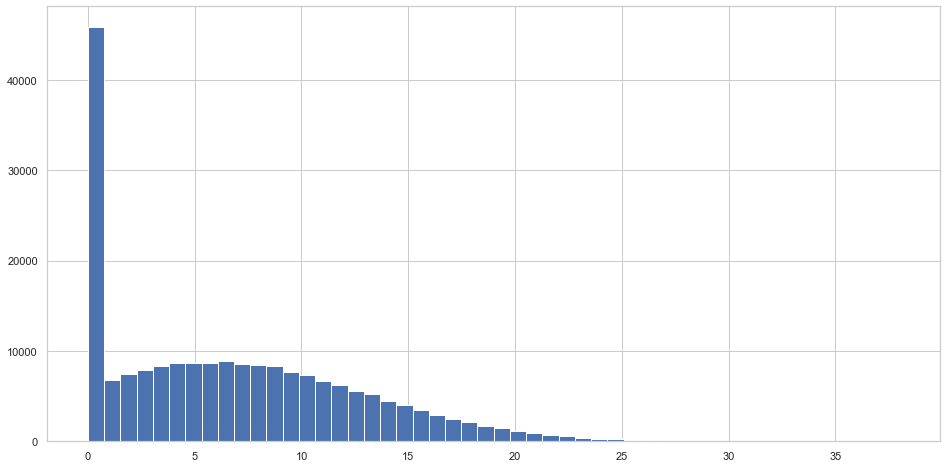

In [54]:
calls['duration'].hist(bins=50)

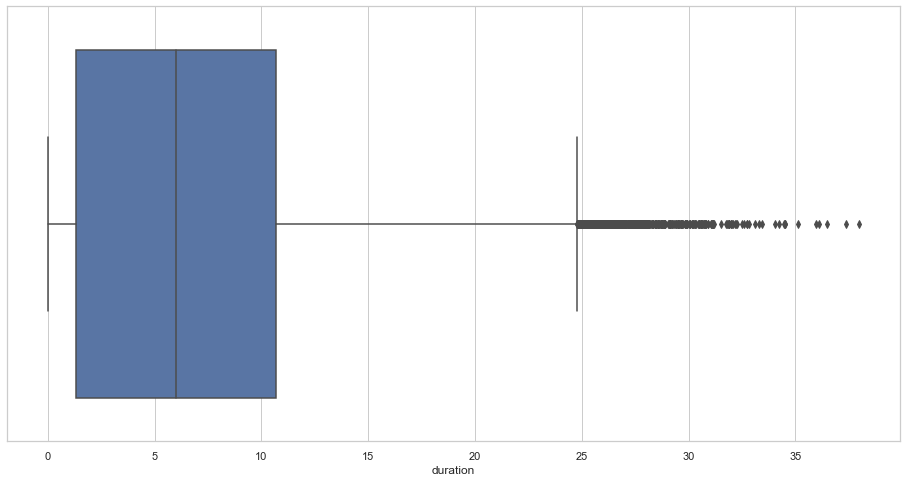

In [55]:
sns.boxplot(calls['duration'])

    Мы видим очень много звонков с продолжительностью 0 минут. Это может быть либо в результате округления продолжительности в меньшую сторону, либо это могут быть пропущенные звонки. Проверим.

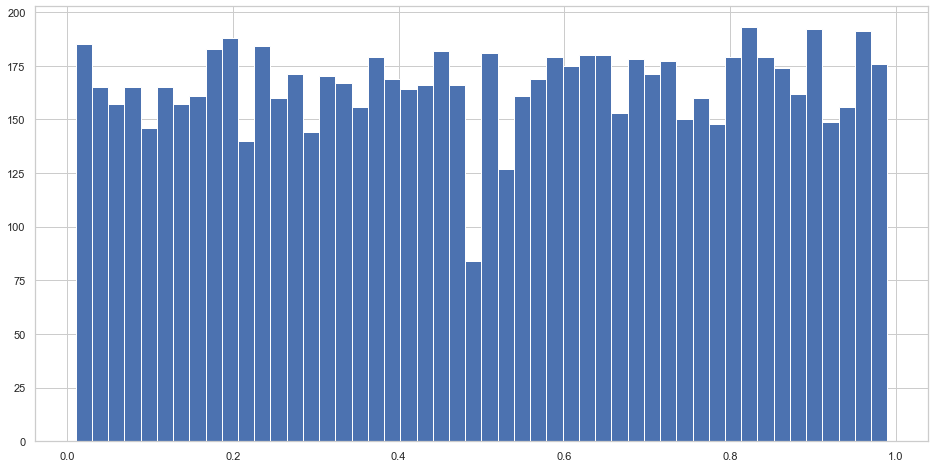

In [56]:
calls.query('0 < duration < 1')['duration'].hist(bins=50)

    Видно, что количество звонков с продолжительностью до 1 минуты распределено равномерно, а значение с прод. 0 минут сильно выбивается. Больше похоже на то, что это звонки, когда человек так и не смог дозвониться. Посмотрим какую часть от всех звонков составляют такие звонки.

In [57]:
# посмотрим, какую часть от всех звонков составляют звонки продолжительностью 0 сек.
calls.query('duration == 0')['duration'].shape[0] / calls.query('duration > 0')['duration'].shape[0]

0.24303348589518634

    Все выглядит правдободобно, непринятые звонки вполне могут составлять 25% от всех звонков.

    Т.к. такие звонки бесплатны для клиентов и фактически не являются разговорами, удалим эти записи из таблицы.

In [58]:
calls.drop(calls.query('duration == 0').index, inplace=True)

In [59]:
# Добавим в столбец округленное до целого значение количество минут,
# т.к. в тарифе предусмотрено округление до целого значения минут в большую сторону.
calls['duration_round'] = calls['duration'].apply(math.ceil)

In [60]:
# Добавим колонку с месяцем, извлеченным из даты
calls['month'] = calls['call_date'].dt.month

In [61]:
calls

,id,call_date,duration,user_id,duration_round,month
2,1000_2,2018-06-11,2.85,1000,3,6
3,1000_3,2018-09-21,13.80,1000,14,9
4,1000_4,2018-12-15,5.18,1000,6,12
7,1000_7,2018-08-22,18.31,1000,19,8
8,1000_8,2018-09-15,18.44,1000,19,9
...,...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,1,12
202603,1499_216,2018-10-18,18.83,1499,19,10
202604,1499_217,2018-11-10,10.81,1499,11,11
202605,1499_218,2018-10-06,4.27,1499,5,10


In [62]:
# создадим сводную таблицу с необходимой информацией для дальнейшего анализа
calls_pivot = calls.pivot_table(index=['user_id', 'month'], values='duration_round', aggfunc=['sum']).reset_index()
calls_pivot.columns = ['user_id', 'month', 'sum_minutes']
calls_pivot

,user_id,month,sum_minutes
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466
...,...,...,...
3163,1498,10,247
3164,1499,9,70
3165,1499,10,449
3166,1499,11,612


### internet

In [63]:
internet.describe(include='all')

,id,mb_used,session_date,user_id
count,149396,149396.000000,149396,149396.000000
unique,149396,NaN,365,NaN
top,1409_205,NaN,2018-12-31 00:00:00,NaN
freq,1,NaN,1057,NaN
first,NaN,NaN,2018-01-01 00:00:00,NaN
last,NaN,NaN,2018-12-31 00:00:00,NaN
mean,NaN,370.192426,NaN,1252.099842
std,NaN,278.300951,NaN,144.050823
min,NaN,0.000000,NaN,1000.000000
25%,NaN,138.187500,NaN,1130.000000


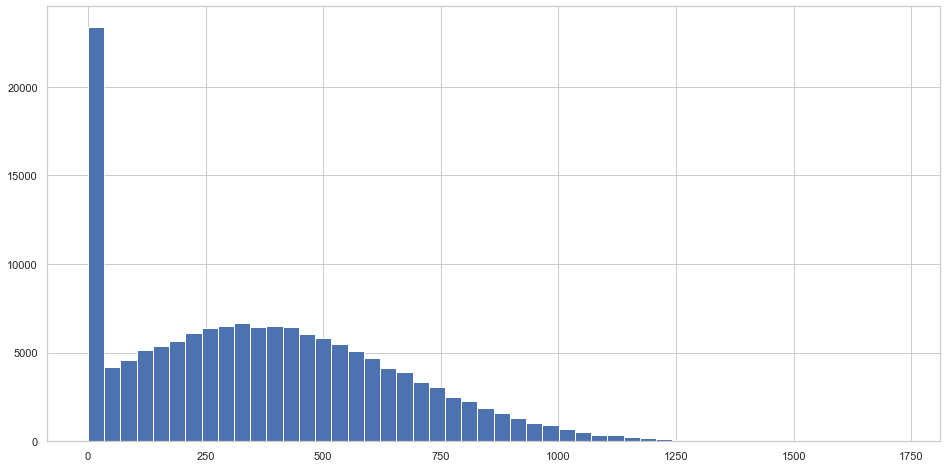

In [64]:
# посмотрим на распределение значений
internet.mb_used.hist(bins=50)

In [65]:
internet.query('mb_used == 0').shape[0]

19598

In [66]:
# посмотрим, какую часть сессий составляют сесии с 0 трафиком
internet.query('mb_used == 0').shape[0] / internet.query('mb_used > 0').shape[0]

0.15098845899012311

    15% сессий с 0 трафиком. Скорее всего это ошибки загрузок или еще что-то. Не понятно почему эти данные попали в таблицу, с этим нужно отдельно разбираться, а сейчас удалим эти строки по аналогии со звонками.

In [67]:
internet.drop(internet.query('mb_used == 0').index, inplace = True)

In [68]:
# Добавим колонку с месяцем, извлеченным из даты
internet['month'] = internet['session_date'].dt.month

In [69]:
# создадим сводную таблицу с необходимой информацией для дальнейшего анализа
internet_pivot = internet.pivot_table(index=['user_id','month'], values='mb_used', aggfunc=['sum']).reset_index()
internet_pivot.columns = ['user_id', 'month', 'sum_mb_used']
internet_pivot

,user_id,month,sum_mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
...,...,...,...
3196,1498,10,20579.36
3197,1499,9,1845.75
3198,1499,10,17788.51
3199,1499,11,17963.31


### messages

In [70]:
messages['month'] = messages['message_date'].dt.month

In [71]:
# создадим сводную таблицу с необходимой информацией для дальнейшего анализа
messages_pivot = messages.pivot_table(index=['user_id', 'month'], values = 'id', aggfunc='count').reset_index()
messages_pivot.columns = ['user_id', 'month', 'sum_messages']
messages_pivot

,user_id,month,sum_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


### Users

In [72]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [73]:
users['reg_month'] = users['reg_date'].dt.month
users['churn_month'] = users['churn_date'].dt.month

In [74]:
users_clear = users.drop(columns=['reg_date', 'churn_date', 'first_name', 'last_name'])

In [75]:
users_clear

,user_id,age,city,tariff,reg_month,churn_month
0,1000,52,Краснодар,ultra,5,NaN
1,1001,41,Москва,smart,11,NaN
2,1002,59,Стерлитамак,smart,6,NaN
3,1003,23,Москва,ultra,8,NaN
4,1004,68,Новокузнецк,ultra,5,NaN
...,...,...,...,...,...,...
495,1495,65,Иркутск,ultra,8,NaN
496,1496,36,Вологда,smart,1,NaN
497,1497,32,Челябинск,smart,10,NaN
498,1498,68,Владикавказ,smart,7,10.0


### Объединим таблицы

In [76]:
all_data =  users_clear \
                .merge(calls_pivot, on=['user_id'], how='left') \
                .merge(internet_pivot, on=['user_id', 'month'], how='left') \
                .merge(messages_pivot, on=['user_id', 'month'], how='left') \
                .merge(tariffs,  left_on = 'tariff' , right_on = 'tariff_name', how='left')

In [77]:
all_data

,user_id,age,city,tariff,reg_month,churn_month,month,sum_minutes,sum_mb_used,sum_messages,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,52,Краснодар,ultra,5,NaN,5.0,159.0,2253.49,22.0,1000,30720,3000,1950,150,1,1,ultra
1,1000,52,Краснодар,ultra,5,NaN,6.0,172.0,23233.77,60.0,1000,30720,3000,1950,150,1,1,ultra
2,1000,52,Краснодар,ultra,5,NaN,7.0,340.0,14003.64,75.0,1000,30720,3000,1950,150,1,1,ultra
3,1000,52,Краснодар,ultra,5,NaN,8.0,408.0,14055.93,81.0,1000,30720,3000,1950,150,1,1,ultra
4,1000,52,Краснодар,ultra,5,NaN,9.0,466.0,14568.91,57.0,1000,30720,3000,1950,150,1,1,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3171,1498,68,Владикавказ,smart,7,10.0,10.0,247.0,20579.36,42.0,50,15360,500,550,200,3,3,smart
3172,1499,35,Пермь,smart,9,NaN,9.0,70.0,1845.75,11.0,50,15360,500,550,200,3,3,smart
3173,1499,35,Пермь,smart,9,NaN,10.0,449.0,17788.51,48.0,50,15360,500,550,200,3,3,smart
3174,1499,35,Пермь,smart,9,NaN,11.0,612.0,17963.31,59.0,50,15360,500,550,200,3,3,smart


In [78]:
# создадим функцию для подсчета месячных трат клиентов в зависимости от тарифа
def raschet(row):
    bill = row['rub_monthly_fee']
    
    if row['sum_minutes'] > row['minutes_included']:
        bill += (row['sum_minutes'] - row['minutes_included']) * row['rub_per_minute']
    
    if row['sum_mb_used'] > row['mb_per_month_included']:
        bill += (row['sum_mb_used'] - row['mb_per_month_included']) / 1000 * row['rub_per_gb']
        
    if row['sum_messages'] > row['messages_included']:
        bill += (row['sum_messages'] - row['messages_included']) * row['rub_per_message']
    
    return bill

In [79]:
all_data['bill'] = all_data.apply(raschet, axis=1)

In [80]:
# избавимся от ненужных столбцов
all_data.drop(columns=tariffs.columns, inplace = True)

<a name="stage_2"></a>
# 2.  Исследовательский анализ данных


[Наверх к оглавлению](#contents)

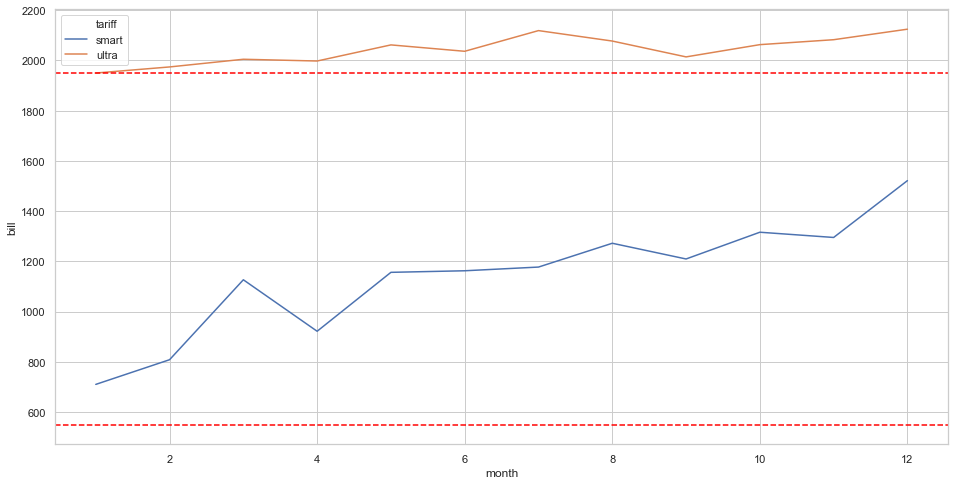

In [81]:
# посмотрим на распределение среднего значения трат клиентов в течении года, в зависимости от тарифа
ax = sns.lineplot(data=all_data.groupby(['month', 'tariff'], as_index=False).agg({'bill': 'mean'}), 
             x='month', 
             y='bill', 
             hue='tariff')
# отметим базовые стоимости тарифов
ax.axhline(550, ls='--', color='red')
ax.axhline(1950, ls='--', color='red')

    Видно, что в обоих тарифах тенденция возрастающая, т.е. клиенты с каждым месяцемм тратят все больше и больше. 
    Причем клиенты более дешевого тарифа, ежемесячно доплачивают сверх базовой стоимости довольно много. Очевидно,
    что клиентам не хватает  какого то среднего тарифа.

### Посмотрим на распределение основных значений в зависимости от тарифа.

In [82]:
# распределение показателей клиентов тарифа Ультра
all_data.query('tariff == "ultra"')[['bill', 'sum_minutes', 'sum_messages', 'sum_mb_used']].describe()

,bill,sum_minutes,sum_messages,sum_mb_used
count,953.000000,947.000000,759.000000,936.000000
mean,2063.239217,547.755016,60.836627,19700.413312
std,366.283443,305.513385,44.436961,9963.327384
min,1950.000000,1.000000,1.000000,365.090000
25%,1950.000000,311.000000,25.000000,11907.832500
50%,1950.000000,529.000000,52.000000,19425.985000
75%,1950.000000,758.000000,87.000000,26933.677500
max,4803.853500,1673.000000,224.000000,49745.690000


In [83]:
# распределение показателей клиентов тарифа Смарт
all_data.query('tariff == "smart"')[['bill', 'sum_minutes', 'sum_messages', 'sum_mb_used']].describe()

,bill,sum_minutes,sum_messages,sum_mb_used
count,2223.000000,2221.000000,1914.000000,2219.000000
mean,1243.867652,419.440342,38.748171,16225.268963
std,802.491651,188.992403,26.829451,5858.784425
min,550.000000,2.000000,1.000000,201.070000
25%,550.000000,285.000000,17.000000,12670.285000
50%,963.624000,423.000000,34.000000,16506.840000
75%,1681.791000,546.000000,55.000000,20047.490000
max,6808.490000,1435.000000,143.000000,38552.450000


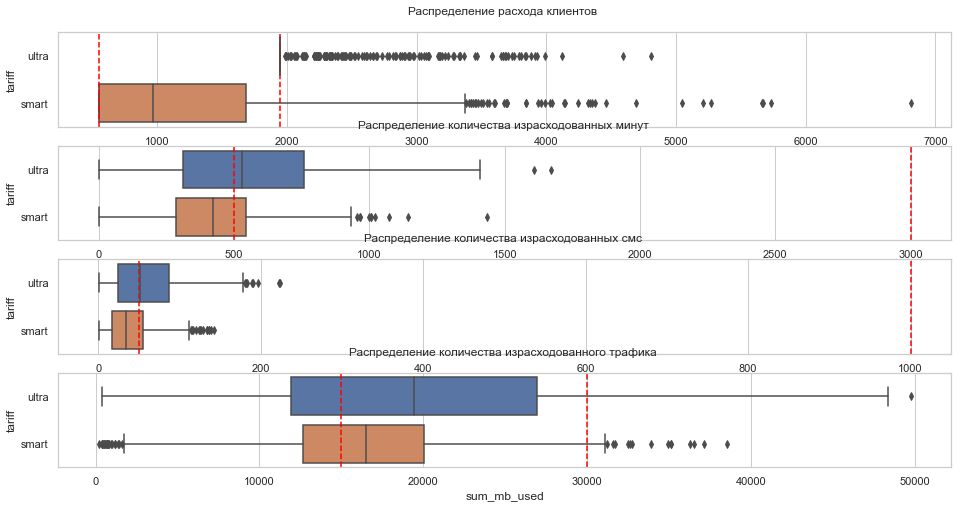

In [84]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16, 8))

# распределение расхода клиентов
ax1 = sns.boxplot(data=all_data, y='tariff', x='bill', orient="h", ax=axes[0])
ax1.set_title('Распределение расхода клиентов \n')
# количество израсходованных минут
ax2 = sns.boxplot(data=all_data, y='tariff', x='sum_minutes', orient="h", ax=axes[1])
ax2.set_title('Распределение количества израсходованных минут \n')
# количество израсходованных смс
ax3 = sns.boxplot(data=all_data, y='tariff', x='sum_messages', orient="h", ax=axes[2])
ax3.set_title('Распределение количества израсходованных смс \n')
# количество израсходованного трафика
ax4 = sns.boxplot(data=all_data, y='tariff', x='sum_mb_used', orient="h", ax=axes[3])
ax4.set_title('Распределение количества израсходованного трафика \n')

# отметим базовые параметры тарифов
ax1.axvline(550, ls='--', color='red')
ax1.axvline(1950, ls='--', color='red')

ax2.axvline(500, ls='--', color='red')
ax2.axvline(3000, ls='--', color='red')

ax3.axvline(50, ls='--', color='red')
ax3.axvline(1000, ls='--', color='red')

ax4.axvline(15000, ls='--', color='red')
ax4.axvline(30000, ls='--', color='red')

<div class="alert alert-info"> <b>Комментарий студента:</b> Не знаю как лучше подписать эти графики, может дашь совет? Сейчас название наплывает на вышесояший график(( Нужно как то раздвинуть axes. Я перелопатил весь интернет, но как это сделать не нашел. Понятно, что можно построить каждый график по отдельности, но я хочу разобрать именно такой случай.</div>

Исходя из распределений, можно сделать выводы:
 * Распределения количества израсходованных минут, у обоих тарифов, лежат по большей части в одном интервале. Ни один из клиентов тарифа Ультра, даже близко не приблизился к максимальному количеству минут.
 * Распределения количества израсходованных смс, у обоих тарифов, лежат по большей части в одном интервале. Ни один из клиентов тарифа Ультра, даже близко не приблизился к максимальному количеству смс.
 * Предоставленного трафика не хватает большей части клиентов тарифа Смарт, с клиентами тарифа Ультра картина вполне адекватная.
 * Необходимо явно пересмотреть пакеты предложений и возможно добавить несколько тарифов.    

### Проверка гипотез.

    Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается?
    Нулевая гипотеза Но: среднии выручки двух тарифов не различаются.
    Альтернативная гипотеза Н1: средние выручки не равны.

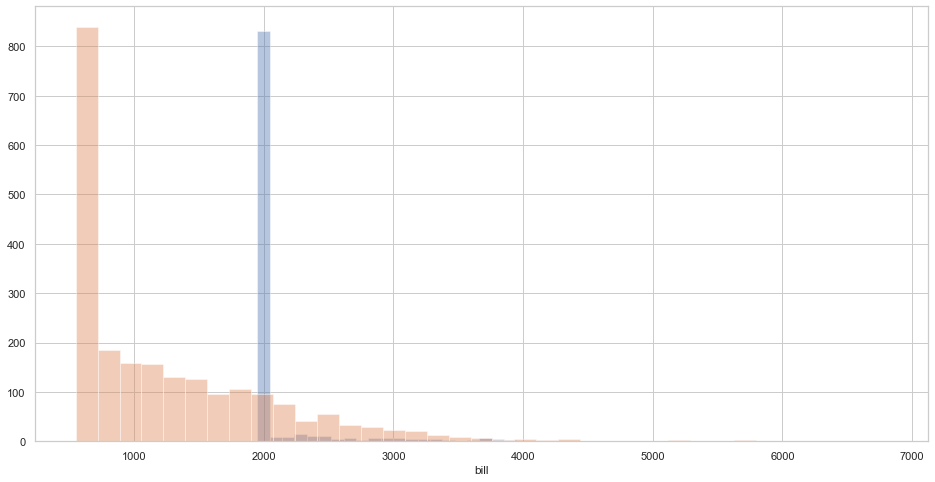

In [85]:
# посмотрим на распределения 2 выборок
sns.distplot(all_data.query('tariff == "ultra"')['bill'], kde=False)
sns.distplot(all_data.query('tariff == "smart"')['bill'], kde=False)

    Визуально довольно четко видно, что распределения далеки от нормальных.

In [86]:
# Дисперсии внутри групп должны быть равны (требование гомогенности дисперсий)
# Тест Левена проверяет нулевую гипотезу о том, что все выборки имеют равную дисперсию.
stat, p =  st.levene(all_data.query('tariff == "ultra"')['bill'],
                     all_data.query('tariff == "smart"')['bill'])

In [87]:
p

3.1536994492980207e-111

    Т.к. распределения далеки от нормальных и дисперсии внутри групп сильно отличаются, проверим нулевую гепотезу с помощью
    непарамметрического теста.

In [88]:
# Непарраметрический U-критерий Манна-Уитни проверяет нулевую гипотезу о том, что выборки имеют одинаковые средние значения
stat, p =  st.mannwhitneyu(all_data.query('tariff == "ultra"')['bill'],
                                     all_data.query('tariff == "smart"')['bill'])

In [89]:
p

1.6456388417384763e-201

    Вероятность того, что средние значения наших выборок принадлежат одной генеральной совокупности стремится к нулю. 
    Отвергаем нулевую гипотезу и делаем вывод, что тариф Ультра приносит больше прибыли оператору, чем тариф Смарт.

    Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов?
    Нулевая гипотеза Но: среднии выручки не различаются.
    Альтернативная гипотеза Н1: средние выручки не равны.

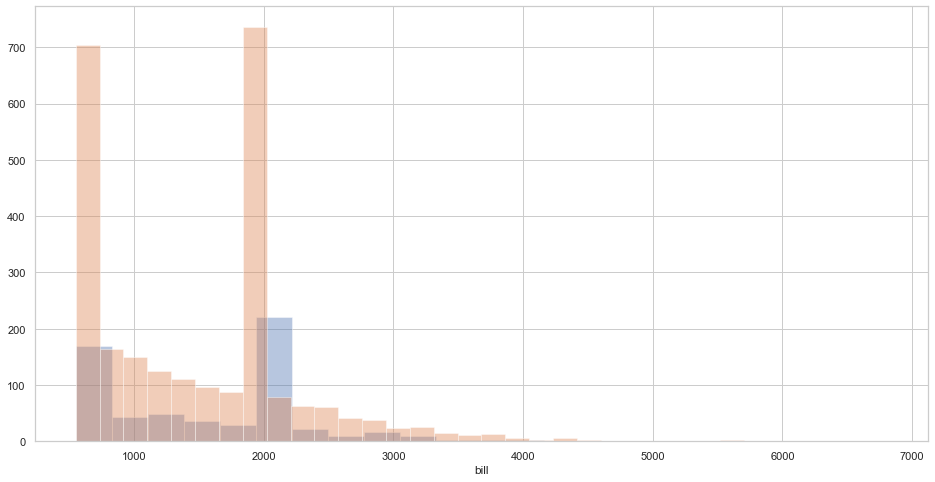

In [90]:
# посмотрим на распределения 2 выборок
sns.distplot(all_data.query('city == "Москва"')['bill'], kde=False)
sns.distplot(all_data.query('city != "Москва"')['bill'], kde=False)

    Визуально довольно четко видно, что распределения далеки от нормальных.

In [91]:
# Дисперсии внутри групп должны быть равны (требование гомогенности дисперсий)
# Тест Левена проверяет нулевую гипотезу о том, что все выборки имеют равную дисперсию.
stat, p =  st.levene(all_data.query('city == "Москва"')['bill'],
                     all_data.query('city != "Москва"')['bill'])

In [92]:
p

0.014422653323977158

    Т.к. распределения далеки от нормальных и дисперсии внутри групп сильно отличаются, проверим нулевую гепотезу с помощью
    непарамметрического теста.

In [93]:
# Непарраметрический U-критерий Манна-Уитни проверяет нулевую гипотезу о том, что выборки имеют одинаковые средние значения
stat, p =  st.mannwhitneyu(all_data.query('city == "Москва"')['bill'],
                                     all_data.query('city != "Москва"')['bill'])

In [94]:
p

0.10700278547401382

    Вероятность того, что средние значения наших выборок принадлежат одной генеральной совокупности равняется 10%. 
    Несмотря на то, что это довольно мало, отклонить нулевую гипотезу мы не можем.

<a name="stage_3"></a>
# 3. Результаты исследования.


[Наверх к оглавлению](#contents)

* Базовый пакет (минут, смс и трафика) тарифа Смарт удовлетворяет большую часть своих клиентов только количеством минут и смс, а вот трафика не хватает почти всем клиентам, в результате чего им приходится доплачивать и реальная стоимость тарифа может быть увеличена в разы.
* Базовый пакет (минут, смс и трафика) тарифа Ультра удовлетворяет своих клиентов наоборот только количеством трафика, количество минут и смс слишком завышено и находится очень далеко от реальных потребностей клиентов.
* Необходимо реструктурировать существующие тарифы и настроить их под клиентов, с целью сокращения их оттока к более гибким операторам связи.
* Для оператора более выгоден тариф Ультра, на нем он зарабатывает больше денег с клиента.